# Co-clustering with Dask Async

## Dask

In [1]:
import dask
dask.config.set(scheduler='distributed') 

In [2]:
from dask.distributed import Client

In [3]:
client = Client("parrot0.phenovari-utwente.surf-hosted.nl:9091", threads_per_worker=2, n_workers=10, asynchronous=True, processes=True)

In [4]:
client

<Client: scheduler='tcp://145.100.59.141:9091' processes=4 cores=64>

## Co-Clustering

In [5]:
import numpy as np
import dask.array as da
import xarray as xr
import time

In [6]:
def idivdist2_da(Z, X, Y, options):
    if len(options) > 0:
        epsilon = options[0]
    else:
        epsilon = 10 ** (-8)
    Y = Y + epsilon
    d = da.dot(X, Y.T) - da.dot(Z, da.log(Y.T))
    return d

In [7]:
def co_group_avg(Z, R,C):
    '''
    This function creates a grouped pixel average array (G) from the original data (Z) based on the CoClustering results (R and C matrix).
    
    this is important to plot the new generated data. 
    
    Assuming:
    columns (C) - temporal data
    rows (R) - spatial data
    
    G=[[column_group1:[rowGroup1,rowGroup2...]],[column_Group2:[rowGroup1,rowGroup2...]],...]
    G=[temporalGroup1:[pixelAvg1],temporalGroup2:[pixelAvg2]]
    '''

#     vv=np.dot(np.dot(R.T,Z),C)/np.dot(np.dot(R.T, np.ones((Z.shape[0], Z.shape[1]))), C)
#     print(vv)
#     
#     The folowing creates a matrix with the original size of Z with the averaged values per group
#     vvv=np.dot(np.dot(R,np.dot(np.dot(R.T,Z),C)/np.dot(np.dot(R.T, np.ones((Z.shape[0], Z.shape[1]))), C)),C.T)
#     print (vvv)
    
    #G=np.transpose(np.dot(R,np.dot(np.dot(R.T,Z),C)/np.dot(np.dot(R.T, np.ones((Z.shape[0], Z.shape[1]))), C)))
    a = np.dot(np.dot(R.T,Z),C)
    b = np.dot(np.dot(R.T, np.ones((Z.shape[0], Z.shape[1]))), C)
    G = np.transpose(np.dot(R,a/(b+np.finfo(np.float64).eps)))
    return G

## coclust_idiv

```
# function [val,R,C] = coclust_idiv(Z,k,l,z,scheme, options)
# %
# %	Description
# %	[R,C] = COCLUST_IDIV(Z,K,L,OPTIONS)
# %       Inputs:
# %       Z - m x n data matrix,
# %       k - num row clusters,
# %       l - num col clusters,
# %       scheme - co-clustering scheme (1-6)
# %       OPTIONS(1) - precision of obj fun for convergence; default 1e-3.
# %       OPTIONS(2) - max iterations; default 20
# %       OPTIONS(3) - max runs; default 5
# %       OPTIONS(4) - precision of matrix elements: default 10^(-8)
# %
# %       Outputs:
# %       R - final row clustering ,
# %       C - final column clustering.
# %
# %------------------------------------------------------------------------------
```

In [8]:
def coclust_idiv_Client_da_While(Y_da, Y_da_T, Gavg_da, Em_da, En_da, m_n_ones_da, idk_da, idl_da, kwargs):
    from dask.distributed import get_client
    my_client = get_client("parrot0.phenovari-utwente.surf-hosted.nl:9091")
    
    epsilon = kwargs[0]
    errobj = kwargs[1]
    niters = kwargs[2]
    m = kwargs[3]
    n = kwargs[4]
    k = kwargs[5]
    l = kwargs[6]

    #PR
    pr_np_1 = np.zeros(m)
    for g in range(0, k):
        ind = range(int((g - 1) * da.floor(m / k)), int(g * da.floor(m / k)))
        pr_np_1[ind] = g
    pr_np_1[int(k * da.floor(m / k)):m] = k - 1
    #pr_da_1 = da.from_array(pr_np_1, chunks=np.floor(m/4))
    pr_da_1 = da.from_array(pr_np_1, chunks=100000)

    rd_pc_np = np.random.permutation(m)
    #rd_pc_da = da.from_array(rd_pc_np, chunks=np.floor(m/4))
    rd_pc_da = da.from_array(rd_pc_np, chunks=100000)

    data_pr = [ rd_pc_da, pr_da_1]
    pr_da = da.stack(data_pr, axis=1)
    pr_da = pr_da.astype(np.int64)
    print("PR_DA done!!!")

    #R
    ##data_R = idk_da[pr_da[0:m,1].compute(), :]
    data_R = idk_da[pr_da[:,1],:]
    R_da = data_R
    #data_R = [ idk_da[int(pr_da[t,1]), :] for t in range(m)]
    #R_da = da.stack(data_R)

    R_da = R_da.persist()
    R_da_T = R_da.T.persist()
    #R = client.persist(R_da)
    print("R_DA done!!!")

    #PC
    pc_np_1 = np.zeros(n)
    for h in range(0, l):
        ind = range(int((h - 1) * np.floor(n / l) + 1), int(h * np.floor(n / l)))
        pc_np_1[ind] = h
    pc_np_1[int(l * da.floor(n / l)):n] = l - 1
    #pc_da_1 = da.from_array(pc_np_1, chunks=np.floor(n/4))
    pc_da_1 = da.from_array(pc_np_1, chunks=n)

    rd_pc_np = np.random.permutation(n)
    #rd_pc_da = da.from_array(rd_pc_np, chunks=np.floor(n/4))
    rd_pc_da = da.from_array(rd_pc_np, chunks=n)

    data_pc = [ rd_pc_da, pc_da_1]
    pc_da = da.stack(data_pc, axis=1)
    pc_da = pc_da.astype(np.int64)
    print("PC_DA done!!!")

    #C
    ##data_C = idl_da[pc_da[0:n,1].compute(), :]
    data_C = idl_da[pc_da[:,1],:]
    C_da = data_C
    C_da = C_da.persist()

    #C = client.persist(C_da)
    print("C_DA done!!!")

    e = 2 * errobj
    old_e = 0
    s = 1

    #print("---D: %s seconds ---" % (time.time() - start_time))
    while (abs(e - old_e) > errobj) & (s <= niters):
        print("iteration number: " + str(s))
        start_time = time.time()

        CoCavg_da = (da.dot(da.dot(R_da_T, Y_da), C_da) + Gavg_da*epsilon) / (da.dot(da.dot(R_da_T, m_n_ones_da), C_da) + epsilon)
        #CoCavg_da = CoCavg_da.persist()

        ###RCavg_da = (da.dot(da.dot(R_da.T, Y_da), En_da) + Gavg_da*epsilon) / (da.dot(da.dot(R_da.T, m_n_ones_da), En_da) + epsilon)

        ###CCavg_da = (da.dot(da.dot(Em_da.T, Y_da), C_da) + Gavg_da*epsilon) / (da.dot(da.dot(Em_da.T, m_n_ones_da), C_da) + epsilon)

        ###RC_Cavg_da = (da.dot(R_da.T, Y_da) + Gavg_da*epsilon) / (da.dot(R_da.T, m_n_ones_da) + epsilon)

        ###CC_Ravg_da = (da.dot(Y_da, C_da) + Gavg_da*epsilon) / (da.dot(m_n_ones_da, C_da) + epsilon)

        Zrowc_da = m_n_ones_da

        Zrowv_da = da.dot(CoCavg_da, C_da.T)

        d2_da = idivdist2_da(Y_da, Zrowc_da, Zrowv_da, [])
        d2_da = d2_da.persist()

        index = da.argmin(d2_da, axis=1)
        R_da = idk_da[index, :]
        R_da = R_da.persist()
        R_da_T = R_da.T.persist()

        #start_time = time.time()
        Zcolc_da = m_n_ones_da

        Zcolv_da = da.dot(R_da, CoCavg_da)

        d2_da = idivdist2_da(Y_da_T, Zcolc_da.T, Zcolv_da.T, [])
        d2_da = d2_da.persist()

        minvals_da = da.min(d2_da, axis=1)
        ##minvals_da = minvals_da.persist()

        index = da.argmin(d2_da, axis=1)
        C_da = idl_da[index, :]
        C_da = C_da.persist()

        old_e = e
        e = da.sum(da.power(minvals_da, 1)).compute() # power 1 divergence, power 2 euclidean

        s = s + 1
        print("---8: %s seconds ---" % (time.time() - start_time))
        #print("e: " + str(e))
        #print("old_e: " + str(old_e))

    print("Compute e!!!")
    e = e
    print("R_da persist!!!")
    R = R_da.persist()
    print("C_da persist!!!")
    C = C_da.persist()

    return (e, R, C)

In [9]:
async def coclust_idiv_Client_da_For(Z, k, l, scheme, options):
    # % Sort out the options
    # noptions =size(options,1);

    noptions = len(options)
    
    print("noptions = " + str(noptions))

    if noptions < 1:
        errobj = 0.00001
    else:
        errobj = options[0]

    if noptions < 2:
        niters = 100
    else:
        niters = options[1]

    if noptions < 3:
        nruns = 1
    else:
        nruns = options[2]

    if noptions < 4:
        epsilon = 10 ** (-8)
    else:
        epsilon = options[3]

    # % get data matrix size and fixed averages(upload rows)
    [m, n] = Z.shape
    Y_da = Z.persist()
    Y_da_T = Y_da.T.persist()
    
    Em_da = da.ones((m, 1)) #OK
    Em_da = Em_da.persist()
    
    En_da = da.ones((n, 1)) #OK
    En_da = En_da.persist()
    
    m_n_ones_da = da.ones((m,n))
    print("m_n_ones_da persist!!!")
    m_n_ones_da = m_n_ones_da.persist()
        
    Gavg_da = (da.dot(da.dot(Em_da.T, Y_da), En_da)) / (da.dot(da.dot(Em_da.T, m_n_ones_da), En_da)) #OK
    #Gavg = client.submit(funcGavg, Em.result(), Y.result(), En.result())
    print("Gavg_da persist!!!")
    Gavg_da = Gavg_da.persist()
    
    #Ravg = (np.dot(Y, En)+Gavg*epsilon) / (np.dot(np.ones((m, n)), En)+epsilon) #OK
    #Cavg = (np.dot(Em.T, Y)+Gavg*epsilon) / (np.dot(Em.T, np.ones((m, n)))+epsilon) #OK
    
    idk_da = da.eye(N=k, chunks=k, k=0)
    print("idk_da persist!!!")
    idk_da = idk_da.persist()

    idl_da = da.eye(N=l, chunks=l, k=0)
    print("idl_da persist!!!")
    idl_da = idl_da.persist()
    
    # % ------------------------------------------------------------------------------
    # % Loop over the runs
    Rfinalobj = {} #np.zeros((nruns, 1)) #Precision issue
    RR = {}
    RC = {}
    future_res = {}
    
    print("num of runs: " + str(nruns))
    for r in range(nruns):
        print("Number of run scheduled: " + str(r))
        future_res[r] = client.submit(coclust_idiv_Client_da_While, Y_da, Y_da_T, Gavg_da, Em_da, En_da, m_n_ones_da, idk_da, idl_da, kwargs=[epsilon, errobj, niters, m, n, k, l]) 
    
    for r in range(nruns):
        print("Number of runs gathered: " + str(r))
        start_time_for = time.time()
        #res = await client.gather(future_res[r])
        res = await future_res[r].result()
        Rfinalobj[r] = res[0]
        RR[r] = res[1]
        RC[r] = res[2]
        print("---: Run done in %s seconds ---" % (time.time() - start_time_for))
        
    val = np.min(Rfinalobj)
    ind = np.argmin(Rfinalobj)
    print("get R1")
    R1 = RR[ind]
    print("get C1")
    C1 = RC[ind]
    return R1, C1, val

## Toy examples

In [10]:
scheme = 2
k=2
l=3
options = [0.00001, 100, 15, 10 ** (-8)]
Z = np.array([[ 24.,  44.,   5.,   6.,  26., 100.,  20.,  95.],
       [38.,  14.,  10.,  36.,  56.,  75.,   0.,  26.],
       [0.,  54.,  59.,  45.,  87.,  65.,  28.,  36.],
       [34.,  45.,  95.,  54.,  78.,  56.,  82.,  63.],
       [4.,  63.,  82.,  56.,  36.,  96.,  45.,  34.],
       [24.,  25.,   9.,   2.,  28.,  57.,  76.,  23.]])

Z_da = da.from_array(Z, chunks=(2,4))
#Z_Dask.persist()
#Z_Dask = client.scatter(Z)

###[R, C, val] = coclust_idiv_Client_da(Z_da, k, l, scheme, options)
res = await coclust_idiv_Client_da_For(Z_da, k, l, scheme, options)
R = res[0]
C = res[1]
val = res[2]

noptions = 4
m_n_ones_da persist!!!
Gavg_da persist!!!
idk_da persist!!!
idl_da persist!!!
num of runs: 15
Number of run scheduled: 0
Number of run scheduled: 1
Number of run scheduled: 2
Number of run scheduled: 3
Number of run scheduled: 4
Number of run scheduled: 5
Number of run scheduled: 6
Number of run scheduled: 7
Number of run scheduled: 8
Number of run scheduled: 9
Number of run scheduled: 10
Number of run scheduled: 11
Number of run scheduled: 12
Number of run scheduled: 13
Number of run scheduled: 14
Number of runs gathered: 0
---: Run done in 1.2780065536499023 seconds ---
Number of runs gathered: 1
---: Run done in 0.00519871711730957 seconds ---
Number of runs gathered: 2
---: Run done in 0.004244089126586914 seconds ---
Number of runs gathered: 3
---: Run done in 0.006106376647949219 seconds ---
Number of runs gathered: 4
---: Run done in 0.0041921138763427734 seconds ---
Number of runs gathered: 5
---: Run done in 0.0051059722900390625 seconds ---
Number of runs gathere

In [11]:
print('CoClustering results:')
print('Val: ', val)
print('Row matrix: ', R.compute())
print('Column matrix: ', C.compute())

CoClustering results:
Val:  {0: -6054.97143031733, 1: -6054.97143031733, 2: -6054.97143031733, 3: -6054.97143031733, 4: -6054.97143031733, 5: -6054.97143031733, 6: -6054.97143031733, 7: -6054.97143031733, 8: -6054.97143031733, 9: -6054.97143031733, 10: -6054.97143031733, 11: -6054.97143031733, 12: -6054.97143031733, 13: -6054.97143031733, 14: -6054.97143031733}
Row matrix:  [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]
Column matrix:  [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


## Real Examples:

In [12]:
from osgeo import gdal
import matplotlib.pyplot as plt

In [13]:
start_year = 1980
end_year = 2017

k=70
l = 5
scheme = 2
runs = 15
iterations = 100
options = [0.00001, iterations, runs, 10 ** (-8)]

# LeafFinal

#### Load the first temporal image:

In [14]:
dataset_name = "LeafFinal_one_band"
tifsrc = gdal.Open('/data/local/files/spring-index/' + dataset_name + '/' + str(start_year) + '.tif')
in_band = tifsrc.GetRasterBand(1)
xSize = in_band.XSize
ySize = in_band.YSize
data = tifsrc.ReadAsArray(0,0,xSize,ySize)
data = data.reshape(-1,1)
nans = np.where(np.isnan(data)== False)[0]

In [15]:
usa_mask_fp = gdal.Open('/data/local/files/usa_mask.tif')
usa_mask_band = usa_mask_fp.GetRasterBand(1)
usa_mask = usa_mask_band.ReadAsArray(0,0,xSize,ySize)
usa_mask = usa_mask.reshape(-1,1)
usa_mask = np.where(np.isnan(usa_mask)== False)[0]

In [16]:
#Merge indices
mask = np.intersect1d(nans, usa_mask)

## Reduce size

In [17]:
data = data[mask,]

In [18]:
data.shape

(10112344, 1)

#### Loop for the rest temporal images:

In [19]:
years = range(start_year+1, end_year+1)
print(years)
root_image = '/data/local/files/spring-index/' + dataset_name + '/'
for yr in years:
    print("year: " + str(yr))
    img = root_image + str(yr) + '.tif'
    tifsrc = gdal.Open(img)
    in_band = tifsrc.GetRasterBand(1)
    xSize = in_band.XSize
    ySize = in_band.YSize

    data2 = tifsrc.ReadAsArray(0,0,xSize,ySize)
    data2 = data2.reshape(-1,1)
    data2 = data2[mask]
    data = np.append(data, data2, axis=1)
print(data.shape)

range(1981, 2018)
year: 1981
year: 1982
year: 1983
year: 1984
year: 1985
year: 1986
year: 1987
year: 1988
year: 1989
year: 1990
year: 1991
year: 1992
year: 1993
year: 1994
year: 1995
year: 1996
year: 1997
year: 1998
year: 1999
year: 2000
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
(10112344, 38)


In [20]:
data = data.astype(dtype=np.int32)
data

array([[113, 119, 119, ..., 111, 118, 114],
       [113, 119, 119, ..., 111, 118, 114],
       [113, 119, 119, ..., 111, 118, 114],
       ...,
       [ 12,  21,   7, ...,   7,   8,   9],
       [ 12,  21,   7, ...,   7,   8,   9],
       [ 12,  21,   7, ...,   7,   8,   9]], dtype=int32)

In [21]:
data.shape

(10112344, 38)

#### Co-clustering:

In [22]:
data_da = da.from_array(data, chunks=(400000,38))
data_da = data_da.persist()
#dataDask = client.scatter(data)

##### Old call
```
start_time = time.time()
[R, C, vals] = coclust_idiv_Client_da(data_da, k, l, scheme, options)
print("Compute R results")
R = R
print("Compute C results")
C = C
val = vals
print("---Total: %s seconds ---" % (time.time() - start_time))
```

##### New call

In [ ]:
start_time = time.time()
res = await coclust_idiv_Client_da_For(data_da, k, l, scheme, options)
R = res[0]
C = res[1]
val = res[2]
print("---Total: %s seconds ---" % (time.time() - start_time))

noptions = 4
m_n_ones_da persist!!!
Gavg_da persist!!!
idk_da persist!!!
idl_da persist!!!
num of runs: 15
Number of run scheduled: 0
Number of run scheduled: 1
Number of run scheduled: 2
Number of run scheduled: 3
Number of run scheduled: 4
Number of run scheduled: 5
Number of run scheduled: 6
Number of run scheduled: 7
Number of run scheduled: 8
Number of run scheduled: 9
Number of run scheduled: 10
Number of run scheduled: 11
Number of run scheduled: 12
Number of run scheduled: 13
Number of run scheduled: 14
Number of runs gathered: 0


### Visualization:

#### Plot time clusters

(38, 5)
(10112344, 70)
[0 1 0 0 0 1 3 2 1 2 3 2 2 0 2 2 2 2 2 3 3 0 2 2 4 2 3 4 0 2 1 0 3 0 0 4 4
 3]


Text(0.5, 0, 'Years')

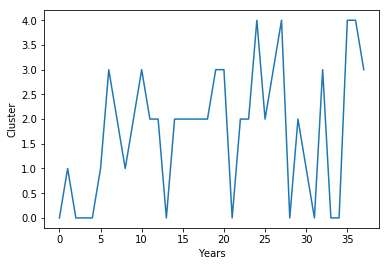

In [24]:
C2 = C
R2 = R
val2 = val
print(C2.shape)
print(R2.shape)
C2_clusters = np.where(C2==1)[1]
print(C2_clusters)
plt.plot(range(0,len(C2_clusters)),C2_clusters)
plt.ylabel('Cluster')
plt.xlabel('Years')


#### Save time clusters

In [25]:
csv_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.csv'
np.savetxt(csv_path, C2, delimiter=",")

#### Plot Spatial Clusters

In [26]:
R_clusters = np.empty(ySize*xSize)
R_clusters[:] =  np.nan
R_clusters_res = np.where(R2==1)[1]
R_clusters[mask] = R_clusters_res
R_clusters = R_clusters.reshape(ySize,xSize)
print(R_clusters.shape)
print(np.unique(R_clusters))


(3892, 7808)
[ 0.  1.  2. ... nan nan nan]


In [27]:
R_clusters_res.shape

(10112344,)

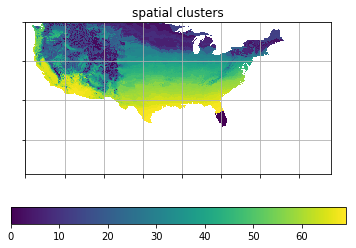

In [28]:
empty_string_labes = ['']
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)
img = plt.imshow(R_clusters)
plt.title('spatial clusters')
ax1.set_yticklabels(empty_string_labes)
ax1.set_xticklabels(empty_string_labes)
plt.colorbar(orientation='horizontal')
ax1.grid(True)
plt.clim(float(0),float(69))

#### Save Spatial Clusters

In [36]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()
band_1 = R_clusters
geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
new_GeoTiff.SetProjection(projection) # export coords to file
new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
new_GeoTiff.FlushCache()                     # write to disk
new_GeoTiff = None  

In [37]:
G = co_group_avg(data, R2, C2)

In [38]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()

for f in range(0,5):
    print("round: " + str(f))
    band_1 = np.empty(ySize*xSize)
    band_1[:] =  np.nan
    band_1[mask] = G[f,]
    band_1 = band_1.reshape(ySize, xSize)
    geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_temp_clust_' + str(f) + '_opts_'+ str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

    new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
    new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
    new_GeoTiff.SetProjection(projection) # export coords to file
    new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
    new_GeoTiff.FlushCache()                     # write to disk
    new_GeoTiff = None 

round: 0
round: 1
round: 2
round: 3
round: 4


# BloomFinal

#### Load the first temporal image:

In [39]:
dataset_name = "BloomFinal_one_band"
tifsrc = gdal.Open('/data/local/files/spring-index/' + dataset_name + '/' + str(start_year) + '.tif')
in_band = tifsrc.GetRasterBand(1)
xSize = in_band.XSize
ySize = in_band.YSize
data = tifsrc.ReadAsArray(0,0,xSize,ySize)
data = data.reshape(-1,1)
nans = np.where(np.isnan(data)== False)[0]

In [40]:
usa_mask_fp = gdal.Open('/data/local/files/usa_mask.tif')
usa_mask_band = usa_mask_fp.GetRasterBand(1)
usa_mask = usa_mask_band.ReadAsArray(0,0,xSize,ySize)
usa_mask = usa_mask.reshape(-1,1)
usa_mask = np.where(np.isnan(usa_mask)== False)[0]

In [41]:
#Merge indices
mask = np.intersect1d(nans, usa_mask)

## Reduce size

In [42]:
data = data[mask,]

In [43]:
data.shape

(10112318, 1)

#### Loop for the rest temporal images:

In [44]:
years = range(start_year+1, end_year+1)
print(years)
root_image = '/data/local/files/spring-index/' + dataset_name + '/'
for yr in years:
    print("year: " + str(yr))
    img = root_image + str(yr) + '.tif'
    tifsrc = gdal.Open(img)
    in_band = tifsrc.GetRasterBand(1)
    xSize = in_band.XSize
    ySize = in_band.YSize

    data2 = tifsrc.ReadAsArray(0,0,xSize,ySize)
    data2 = data2.reshape(-1,1)
    data2 = data2[mask]
    data = np.append(data, data2, axis=1)
print(data.shape)

range(1981, 2018)
year: 1981
year: 1982
year: 1983
year: 1984
year: 1985
year: 1986
year: 1987
year: 1988
year: 1989
year: 1990
year: 1991
year: 1992
year: 1993
year: 1994
year: 1995
year: 1996
year: 1997
year: 1998
year: 1999
year: 2000
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
(10112318, 38)


In [45]:
data = data.astype(dtype=np.int32)
data

array([[140, 146, 144, ..., 145, 118, 149],
       [140, 146, 144, ..., 145, 118, 149],
       [140, 146, 144, ..., 145, 118, 149],
       ...,
       [ 23,  37,  21, ...,  18,  21,  20],
       [ 23,  37,  21, ...,  18,  21,  20],
       [ 23,  37,  21, ...,  18,  21,  20]], dtype=int32)

In [46]:
data.shape

(10112318, 38)

#### Co-clustering:

In [47]:
data_da = da.from_array(data, chunks=(400000,38))
data_da = data_da.persist()
#dataDask = client.scatter(data)

In [48]:
start_time = time.time()
res = await coclust_idiv_Client_da_For(data_da, k, l, scheme, options)
R = res[0]
C = res[1]
val = res[2]
print("---Total: %s seconds ---" % (time.time() - start_time))

noptions = 4
m_n_ones_da persist!!!
Gavg_da persist!!!
idk_da persist!!!
idl_da persist!!!
num of runs: 15
Number of run scheduled: 0
Number of run scheduled: 1
Number of run scheduled: 2
Number of run scheduled: 3
Number of run scheduled: 4
Number of run scheduled: 5
Number of run scheduled: 6
Number of run scheduled: 7
Number of run scheduled: 8
Number of run scheduled: 9
Number of run scheduled: 10
Number of run scheduled: 11
Number of run scheduled: 12
Number of run scheduled: 13
Number of run scheduled: 14
Number of runs gathered: 0
---: Run done in 1505.3321645259857 seconds ---
Number of runs gathered: 1
---: Run done in 0.031479835510253906 seconds ---
Number of runs gathered: 2
---: Run done in 0.03266716003417969 seconds ---
Number of runs gathered: 3
---: Run done in 0.032808542251586914 seconds ---
Number of runs gathered: 4
---: Run done in 0.03030109405517578 seconds ---
Number of runs gathered: 5
---: Run done in 0.02759075164794922 seconds ---
Number of runs gathered: 6

### Visualization:

#### Plot time clusters

(38, 5)
(10112318, 70)
[1 0 1 1 1 0 2 0 0 0 2 3 2 1 0 3 1 3 1 3 2 0 1 0 0 3 2 0 1 3 1 1 2 1 1 0 4
 2]


Text(0.5, 0, 'Years')

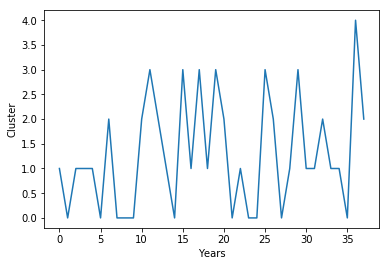

In [49]:
C2 = C
R2 = R
val2 = val
print(C2.shape)
print(R2.shape)
C2_clusters = np.where(C2==1)[1]
print(C2_clusters)
plt.plot(range(0,len(C2_clusters)),C2_clusters)
plt.ylabel('Cluster')
plt.xlabel('Years')


#### Save time clusters

In [50]:
csv_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.csv'
np.savetxt(csv_path, C2, delimiter=",")

#### Plot Spatial Clusters

In [51]:
R_clusters = np.empty(ySize*xSize)
R_clusters[:] =  np.nan
R_clusters_res = np.where(R2==1)[1]
R_clusters[mask] = R_clusters_res
R_clusters = R_clusters.reshape(ySize,xSize)
print(R_clusters.shape)
print(np.unique(R_clusters))


(3892, 7808)
[ 0.  1.  2. ... nan nan nan]


In [52]:
R_clusters_res.shape

(10112318,)

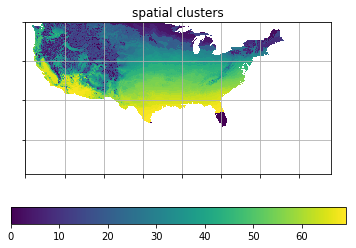

In [53]:
empty_string_labes = ['']
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)
img = plt.imshow(R_clusters)
plt.title('spatial clusters')
ax1.set_yticklabels(empty_string_labes)
ax1.set_xticklabels(empty_string_labes)
plt.colorbar(orientation='horizontal')
ax1.grid(True)
plt.clim(float(0),float(69))

#### Save Spatial Clusters

In [54]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()
band_1 = R_clusters
geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
new_GeoTiff.SetProjection(projection) # export coords to file
new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
new_GeoTiff.FlushCache()                     # write to disk
new_GeoTiff = None  

In [55]:
G = co_group_avg(data, R2, C2)

In [56]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()

for f in range(0,5):
    print("round: " + str(f))
    band_1 = np.empty(ySize*xSize)
    band_1[:] =  np.nan
    band_1[mask] = G[f,]
    band_1 = band_1.reshape(ySize, xSize)
    geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_temp_clust_' + str(f) + '_opts_'+ str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

    new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
    new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
    new_GeoTiff.SetProjection(projection) # export coords to file
    new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
    new_GeoTiff.FlushCache()                     # write to disk
    new_GeoTiff = None 

round: 0
round: 1
round: 2
round: 3
round: 4


# SOST

In [57]:
start_year = 1989
end_year = 2014

k=100
l = 5
scheme = 2
runs = 15
iterations = 100
options = [0.00001, iterations, runs, 10 ** (-8)]

#### Load the first temporal image:

In [58]:
dataset_name = "SOST"
tifsrc = gdal.Open('/data/local/files/avhrr/' + dataset_name + '/av_SOST' + str(start_year) + 'v4_SIx.tif')
in_band = tifsrc.GetRasterBand(1)
xSize = in_band.XSize
ySize = in_band.YSize
data = tifsrc.ReadAsArray(0,0,xSize,ySize)
data = data.reshape(-1,1)
nans = np.where(np.isnan(data)== False)[0]

In [59]:
usa_mask_fp = gdal.Open('/data/local/files/usa_mask.tif')
usa_mask_band = usa_mask_fp.GetRasterBand(1)
usa_mask = usa_mask_band.ReadAsArray(0,0,xSize,ySize)
usa_mask = usa_mask.reshape(-1,1)
usa_mask = np.where(np.isnan(usa_mask)== False)[0]

In [60]:
#Merge indices
mask = np.intersect1d(nans, usa_mask)

## Reduce size

In [61]:
data = data[mask,]
thousands_mask = np.where(data != -1000)

In [62]:
data.shape

(10115631, 1)

#### Loop for the rest temporal images:

In [63]:
years = range(start_year+1, end_year+1)
print(years)
root_image = '/data/local/files/avhrr/' + dataset_name + '/'
for yr in years:
    print("year: " + str(yr))
    img = root_image + 'av_SOST' + str(yr) + 'v4_SIx.tif'
    tifsrc = gdal.Open(img)
    in_band = tifsrc.GetRasterBand(1)
    xSize = in_band.XSize
    ySize = in_band.YSize

    data2 = tifsrc.ReadAsArray(0,0,xSize,ySize)
    data2 = data2.reshape(-1,1)
    data2 = data2[mask]
    thousands = np.where(data2 != -1000)
    thousands_mask = np.intersect1d(thousands_mask,thousands)
    data = np.append(data, data2, axis=1)
print(data.shape)

range(1990, 2015)
year: 1990
year: 1991
year: 1992
year: 1993
year: 1994
year: 1995
year: 1996
year: 1997
year: 1998
year: 1999
year: 2000
year: 2001
year: 2002
year: 2003
year: 2004
year: 2005
year: 2006
year: 2007
year: 2008
year: 2009
year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
(10115631, 26)


In [64]:
len(thousands_mask)

7012087

In [65]:
data = data[thousands_mask, :]

In [66]:
data.shape

(7012087, 26)

#### Co-clustering:

In [67]:
data_da = da.from_array(data, chunks=(400000,38))
data_da = data_da.persist()
#dataDask = client.scatter(data)

In [68]:
start_time = time.time()
res = await coclust_idiv_Client_da_For(data_da, k, l, scheme, options)
R = res[0]
C = res[1]
val = res[2]
print("---Total: %s seconds ---" % (time.time() - start_time))

noptions = 4
m_n_ones_da persist!!!
Gavg_da persist!!!
idk_da persist!!!
idl_da persist!!!
num of runs: 15
Number of run scheduled: 0
Number of run scheduled: 1
Number of run scheduled: 2
Number of run scheduled: 3
Number of run scheduled: 4
Number of run scheduled: 5
Number of run scheduled: 6
Number of run scheduled: 7
Number of run scheduled: 8
Number of run scheduled: 9
Number of run scheduled: 10
Number of run scheduled: 11
Number of run scheduled: 12
Number of run scheduled: 13
Number of run scheduled: 14
Number of runs gathered: 0
---: Run done in 147.11017084121704 seconds ---
Number of runs gathered: 1
---: Run done in 0.017755746841430664 seconds ---
Number of runs gathered: 2
---: Run done in 0.018793821334838867 seconds ---
Number of runs gathered: 3
---: Run done in 0.015195131301879883 seconds ---
Number of runs gathered: 4
---: Run done in 0.010056734085083008 seconds ---
Number of runs gathered: 5
---: Run done in 0.028979778289794922 seconds ---
Number of runs gathered

### Visualization:

#### Plot time clusters

(26, 5)
(7012087, 100)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Text(0.5, 0, 'Years')

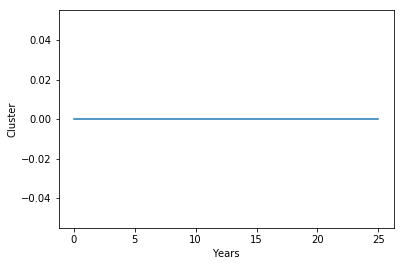

In [69]:
C2 = C
R2 = R
val2 = val
print(C2.shape)
print(R2.shape)
C2_clusters = np.where(C2==1)[1]
print(C2_clusters)
plt.plot(range(0,len(C2_clusters)),C2_clusters)
plt.ylabel('Cluster')
plt.xlabel('Years')


#### Save time clusters

In [70]:
csv_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.csv'
np.savetxt(csv_path, C2, delimiter=",")

#### Plot Spatial Clusters

In [71]:
R_clusters_res = np.where(R2==1)[1]
R_clusters_1000 = np.empty(10115631)
R_clusters_1000[:] =  np.nan
R_clusters_1000[thousands_mask] = R_clusters_res

In [72]:
R_clusters_1000.shape

(10115631,)

In [73]:
R_clusters_res.shape

(7012087,)

In [74]:
R_clusters = np.empty(ySize*xSize)
R_clusters[:] =  np.nan
R_clusters[mask] = R_clusters_1000
R_clusters = R_clusters.reshape(ySize,xSize)
print(R_clusters.shape)
print(np.unique(R_clusters))


(3892, 7808)
[77. nan nan ... nan nan nan]


In [75]:
R_clusters_res.shape

(7012087,)

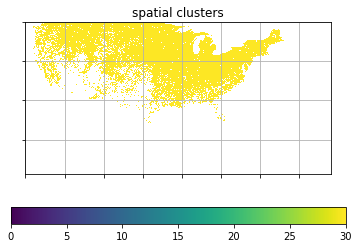

In [76]:
empty_string_labes = ['']
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)
img = plt.imshow(R_clusters)
plt.title('spatial clusters')
ax1.set_yticklabels(empty_string_labes)
ax1.set_xticklabels(empty_string_labes)
plt.colorbar(orientation='horizontal')
ax1.grid(True)
plt.clim(float(0),float(30))

#### Save Spatial Clusters

In [77]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()
band_1 = R_clusters
geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
new_GeoTiff.SetProjection(projection) # export coords to file
new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
new_GeoTiff.FlushCache()                     # write to disk
new_GeoTiff = None  

In [78]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()
band_1 = R_clusters
geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_' + str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
new_GeoTiff.SetProjection(projection) # export coords to file
new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
new_GeoTiff.FlushCache()                     # write to disk
new_GeoTiff = None  

In [79]:
G = co_group_avg(data, R2, C2)

In [80]:
G.shape

(5, 7012087)

In [81]:
nx = xSize
ny = ySize
geotransform = usa_mask_fp.GetGeoTransform()
projection = usa_mask_fp.GetProjection()

for f in range(0,5):
    print("round: " + str(f))  
    G_1000 = np.empty(10115631)
    G_1000[:] =  np.nan
    G_1000[thousands_mask] = G[f,]
    band_1 = np.empty(ySize*xSize)
    band_1[:] =  np.nan
    band_1[mask] = G_1000
    band_1 = band_1.reshape(ySize, xSize)
    geotiff_path = '/data/local/home/parrot/' + str(dataset_name) + '_temp_clust_' + str(f) + '_opts_'+ str(k) + '_' + str(l) + '_' + str(runs) + '_' + str(iterations) + '_new.tif'

    new_GeoTiff = gdal.GetDriverByName('GTiff').Create(geotiff_path, nx, ny, 1, gdal.GDT_Float32, ['COMPRESS=DEFLATE'])
    new_GeoTiff.SetGeoTransform(geotransform)    # specify coords
    new_GeoTiff.SetProjection(projection) # export coords to file
    new_GeoTiff.GetRasterBand(1).WriteArray(band_1)   # write r-band to the raster
    new_GeoTiff.FlushCache()                     # write to disk
    new_GeoTiff = None 

round: 0
round: 1
round: 2
round: 3
round: 4


In [82]:
G[3,100000]

0.0

### Extras

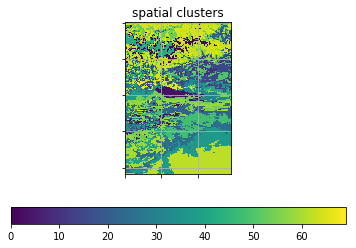

In [96]:
empty_string_labes = ['']
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)
img = plt.imshow(R_clusters)
plt.title('spatial clusters')
ax1.set_yticklabels(empty_string_labes)
ax1.set_xticklabels(empty_string_labes)
plt.colorbar(orientation='horizontal')
ax1.grid(True)
plt.clim(float(0),float(69))

In [41]:
years = [1989] + list(years)
col_cluster = np.unique(C_clusters)
leaf = np.zeros(data.shape)
for tmp in range(len(col_cluster)):
    for spc in range(R.shape[1]):
        temp_ind = np.where(C_clusters==col_cluster[tmp])[0]
        spatial_ind = np.where(R[:,spc]==1)[0]
        leaf[spatial_ind,:] = data[spatial_ind,:]
        leaf[:,temp_ind] = leaf[:,temp_ind]
    
    Leaf_mean = np.mean(leaf[:,temp_ind],axis=1)
    Leaf_mean = Leaf_mean.reshape(ySize,xSize)
    year_cl = [years[i] for i in temp_ind]
    fig1 = plt.figure(tmp)
    ax1 = fig1.add_subplot(1,1,1)
    img = plt.imshow(Leaf_mean)
    plt.title('Leaf mean for temporal cluster ' + str(year_cl))
    ax1.set_yticklabels(empty_string_labes)
    ax1.set_xticklabels(empty_string_labes)
    plt.colorbar(orientation='horizontal')
    ax1.grid(True)
    plt.clim(float(29),float(81))

NameError: name 'C_clusters' is not defined

## Debugging area

In [378]:
def idivdist2_B(Z1, X1, Y1, kwargs):
    if len(kwargs) > 1:
        epsilon = kwargs[1]
    else:
        epsilon = 10 ** (-8)
        
    if kwargs[0] == True:
        Z = Z1.T
        X = X1.T
        Y = Y1.T
    else:
        Z = Z1
        X = X1
        Y = Y1
        
    Y = Y + epsilon
    YT = Y.T
    d = np.dot(X, YT) - np.dot(Z, da.log(YT))
    return d

In [379]:
k=70
l = 4
scheme = 2
options = [0.00001, 10, 1, 10 ** (-10)]
Z = np.array([[ 24.,  44.,   5.,   6.,  26., 100.,  20.,  95.],
       [38.,  14.,  10.,  36.,  56.,  75.,   0.,  26.],
       [0.,  54.,  59.,  45.,  87.,  65.,  28.,  36.],
       [34.,  45.,  95.,  54.,  78.,  56.,  82.,  63.],
       [4.,  63.,  82.,  56.,  36.,  96.,  45.,  34.],
       [24.,  25.,   9.,   2.,  28.,  57.,  76.,  23.]])

Z = da.from_array(Z, chunks=(2,4))

In [380]:
Z = data

In [400]:
# % Sort out the options
# noptions =size(options,1);

noptions = len(options)

if noptions < 1:
    errobj = 0.00001
else:
    errobj = options[0]

if noptions < 2:
    niters = 100
else:
    niters = options[1]

if noptions < 3:
    nruns = 20
else:
    nruns = options[2]

if noptions < 4:
    epsilon = 10 ** (-8)
else:
    epsilon = options[3]

# % get data matrix size and fixed averages(upload rows)
[m, n] = Z.shape
Y = Z
Em = np.ones((m, 1)) #OK
En = np.ones((n, 1)) #OK

Gavg = (np.dot(np.dot(Em.T, Y), En)) / (np.dot(np.dot(Em.T, np.ones((m, n))), En)) #OK
Ravg = (np.dot(Y, En)+Gavg*epsilon) / (np.dot(np.ones((m, n)), En)+epsilon) #OK
Cavg = (np.dot(Em.T, Y)+Gavg*epsilon) / (np.dot(Em.T, np.ones((m, n)))+epsilon) #OK


# % ------------------------------------------------------------------------------
# % Loop over the runs
Rfinalobj = da.zeros((nruns, 1)) #Precision issue
RR = {}
RC = {}

idk = np.identity(k)
#idk = da.eye(N=k, chunks=4, k=0) #OK

idl = np.identity(l)
#idl = da.eye(N=l, chunks=4, k=0) #OK

#pr = da.zeros((m, 2))
#R = da.zeros((m, k))
#pc = da.zeros((n, 2))
#C = da.zeros((n, l))

m_n_ones = np.ones((m,n))    #To be checked

In [401]:
r = 0
print("run numbers: " + str(r))
start_time = time.time()

#PR
pr = np.zeros((m, 2))
np.random.seed(20)
rd = np.random.rand(m)

def setCol(pr, rd, kwargs):
    pr[:,0] = rd
    return pr

pr = client.submit(setCol, pr, rd, kwargs=[m])

def updateFunPR(pr,kwargs):
    g = kwargs[0]
    m = kwargs[1]
    k = kwargs[2]
    ind = range(int((g - 1) * np.floor(m / k)), int(g * np.floor(m / k)))
    pr[ind,1] = int(g)
    return pr

for g in range(0, k):
    pr = client.submit(updateFunPR,pr,kwargs=[g,m,k])

def func3(pr, kwargs):
    m = kwargs[0]
    k = kwargs[1]
    pr[int(k * np.floor(m / k)):m, 1] = k-1
    pr = pr[pr[:, 0].argsort()]
    return pr

pr = client.submit(func3,pr,kwargs=[m,k])

#R
R = np.zeros((m, k))

def func4(R, idk, pr, kwargs):
    m = kwargs[0]
    for t in range(m):
        R[t, :] = idk[int(pr[t,1]), :]
    return R

pr = client.gather(pr)
R = client.submit(func4, R, idk, pr, kwargs=[m])

#PC
pc = np.zeros((n, 2))
np.random.seed(20)
rpc = np.random.rand(n)

pc = client.submit(setCol, pc, rpc, kwargs=[n])

def updateFunPC(pc,kwargs):
    h = kwargs[0]
    n = kwargs[1]
    l = kwargs[2]
    ind = range(int((h - 1) * np.floor(n / l) + 1), int(h * np.floor(n / l)))
    pc[ind,1] = int(h)
    return pc

for h in range(0, l):
    pc = client.submit(updateFunPC,pc,kwargs=[h,n,l])

pc = client.submit(func3,pc,kwargs=[n,l])

#C
C = np.zeros((n, l))
C = client.submit(func4, C, idl, pc, kwargs=[n])

e = 2 * errobj
old_e = 0
s = 1

#print("---D: %s seconds ---" % (time.time() - start_time))

run numbers: 0


In [402]:
print("iteration number: " + str(s))
start_time = time.time()

def funCavg(R, Y, C, Gavg, m_n_ones, kwargs):
    epsilon = kwargs[0]
    Cavg = (np.dot(np.dot(R.T, Y), C) + Gavg*epsilon) / (np.dot(np.dot(R.T, m_n_ones), C) + epsilon)
    return Cavg

#CoCavg = (da.dot(da.dot(R.T, Y), C) + Gavg*epsilon) / (da.dot(da.dot(R.T, m_n_ones), C) + epsilon)
CoCavg = client.submit(funCavg, R, Y, C, Gavg, m_n_ones, kwargs=[epsilon])
#RCavg = (da.dot(da.dot(R.T, Y), En) + Gavg*epsilon) / (da.dot(da.dot(R.T, m_n_ones), En) + epsilon)
RCavg = client.submit(funCavg, R, Y, En, Gavg, m_n_ones, kwargs=[epsilon])
#CCavg = (da.dot(da.dot(Em.T, Y), C) + Gavg*epsilon) / (da.dot(da.dot(Em.T, m_n_ones), C) + epsilon)
CCavg = client.submit(funCavg, Em, Y, C, Gavg, m_n_ones, kwargs=[epsilon])

#RC_Cavg = (da.dot(R.T, Y) + Gavg*epsilon) / (da.dot(R.T, m_n_ones) + epsilon)
def funRC_Cavg(R, Y, Gavg, m_n_ones, kwargs):
    epsilon = kwargs[0]
    Cavg = (np.dot(R.T, Y) + Gavg*epsilon) / (np.dot(R.T, m_n_ones) + epsilon)
    return Cavg

RC_Cavg = client.submit(funRC_Cavg, R, Y, Gavg, m_n_ones, kwargs=[epsilon])

#CC_Ravg = (da.dot(Y, C) + Gavg*epsilon) / (da.dot(m_n_ones, C) + epsilon)
def funCC_Ravg(Y, C, Gavg, m_n_ones, kwargs):
    epsilon = kwargs[0]
    Cavg = (np.dot(Y, C) + Gavg*epsilon) / (np.dot(m_n_ones, C) + epsilon)
    return Cavg


CC_Ravg = client.submit(funCC_Ravg, Y, C, Gavg, m_n_ones, kwargs=[epsilon])

def mult(x, y, kwargs):
    if kwargs[0] == True:
        res = np.dot(x,y.T)
    else:
        res = np.dot(x,y)
    return res

Zrowc = m_n_ones
#Zrowv = da.dot(CoCavg, C.T)
Zrowv = client.submit(mult, CoCavg, C, kwargs=[True])

#d2 = idivdist2(Y, Zrowc, Zrowv, [])
d2 = client.submit(idivdist2_B, Y, Zrowc, Zrowv, kwargs=[False])

#index = da.argmin(d2, axis=1)
#R = idk[index, :]
def funcArgmin(d2, idk):
    index = np.argmin(d2, axis=1)
    return idk[index, :]

R = client.submit(funcArgmin, d2, idk)

#start_time = time.time()
Zcolc = m_n_ones
#Zcolv = da.dot(R, CoCavg)
Zcolv = client.submit(mult, R, CoCavg, kwargs=[False])

#d2 = idivdist2(Y.T, Zcolc.T, Zcolv.T, [])
d2 = client.submit(idivdist2_B, Y, Zcolc, Zcolv, kwargs=[True])

#minvals = da.min(d2, axis=1)
def funcMin(d2):
    return np.min(d2, axis=1)

minvals = client.submit(funcMin, d2)

#index = da.argmin(d2, axis=1)
#C = idl[index, :]
C = client.submit(funcArgmin, d2, idl)

old_e = e
#e = sum(da.power(minvals, 1)).compute() # power 1 divergence, power 2 euclidean
def funcSum(minvals):
    return sum(np.power(minvals, 1))
    
e = client.submit(funcSum, minvals)
e = client.gather(e)

s = s + 1
print("---8: %s seconds ---" % (time.time() - start_time))
#print("e: " + str(e))
#print("old_e: " + str(old_e))

iteration number: 1


In [416]:
#Rfinalobj[r] = e
Rfinalobj = Rfinalobj.map_blocks(dask_array_mutation_1D_val, dtype='int64', kwargs=[r, e])

RR[r] = R
RC[r] = C

In [423]:
val = da.min(Rfinalobj)
ind = da.argmin(Rfinalobj)
R1 = RR[ind.compute()]
C1 = RC[ind.compute()]

(210, 147)
[ 0  1  2  3  7 11 19 21 22 30 35 36 37 38 39 41 42 43 47 48 49 50 51 52
 53 54 58 59 61 63 64 65 67 68 69]


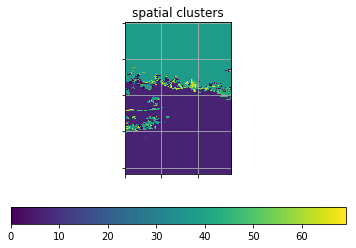

In [426]:
R_clusters = np.where(R1==1)[1]
R_clusters = R_clusters.reshape(ySize,xSize)
print(R_clusters.shape)
print(np.unique(R_clusters))
empty_string_labes = ['']
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(1,1,1)
img = plt.imshow(R_clusters)
plt.title('spatial clusters')
ax1.set_yticklabels(empty_string_labes)
ax1.set_xticklabels(empty_string_labes)
plt.colorbar(orientation='horizontal')
ax1.grid(True)
plt.clim(float(0),float(69))

In [55]:
print('CoClustering results:')
print('Val: ', val.compute())
print('Row matrix: ', R1.compute())
print('Column matrix: ', C1.compute())

CoClustering results:
Val:  -125302543.91075641
Row matrix:  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
Column matrix:  [[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


## Testing area

### 1D

In [206]:
h = np.array([10,2,3,4,5,6,7,8])
e = da.asarray(h)
e.compute()

array([10,  2,  3,  4,  5,  6,  7,  8])

In [217]:
def dask_array_mutation_1D_val(block, block_info, kwargs):
    #Get overlap slice
    block_row = block_info[0]["array-location"][0]
    input_row = kwargs[0]
    
    if (kwargs[0] is not None):
        if (isinstance(kwargs[0],tuple)):
            if (input_row[0] >= block_row[1]):
                return block
            if (input_row[1] <= block_row[0]):
                return block
            row_start = 0 if ((input_row[0] - block_row[0]) <= 0) else (input_row[0] - block_row[0])
            row_stop = ((input_row[1]-block_row[0]) if ((input_row[1] - block_row[1]) < 0) else (block_row[1] - block_row[0]))
        else:
            if (input_row >= block_row[1]):
                return block
            if (input_row < block_row[0]):
                return block
            row_start = input_row - block_row[0]
    
    if (kwargs[0] is not None):   
        block[slice(row_start,row_stop) if isinstance(kwargs[0],tuple) else row_start] = kwargs[1]
    else:
        block[:] = kwargs[1]
        
    return block

e.map_blocks(dask_array_mutation_1D_val, dtype='int64', kwargs=[1, 100]).compute()

array([ 10, 100,   3,   4,   5,   6,   7,   8])

### 2D

In [83]:
h = np.array([[10,2,3,4,5,6,7,8],[14,5,6,6,7,8,9,10],[7,8,9,9,10,11,12,13],[1,11,12,13,14,15,16,17]])

d = da.asarray(h).rechunk(2,2)
e = da.asarray(h).rechunk(2,2)
e.compute()
f = e

In [84]:
def dask_array_mutation_2D_val(block, block_info, kwargs):
    #Get overlap slice
    block_row = block_info[0]["array-location"][0]
    block_col = block_info[0]["array-location"][1]
    input_row = kwargs[0]
    input_col = kwargs[1]
    
    #To read properly the values
    row_val_start = 0
    row_val_stop = 1
    col_val_start = 0
    col_val_stop = 1
    
    if (isinstance(kwargs[2], np.ndarray) and len(kwargs[2].shape) == 1):
        if (kwargs[0] is None or isinstance(kwargs[0],tuple)):
            row_val_len = kwargs[2].shape[0] if isinstance(kwargs[2], np.ndarray) else 1
            col_val_len = 1
        elif (kwargs[1] is None or isinstance(kwargs[1],tuple)):
            row_val_len = 1
            col_val_len = kwargs[2].shape[0] if isinstance(kwargs[2], np.ndarray) else 1
    elif (isinstance(kwargs[2], np.ndarray) and len(kwargs[2].shape) == 2):
        row_val_len = kwargs[2].shape[0] if isinstance(kwargs[2], np.ndarray) else 1
        col_val_len = kwargs[2].shape[1] if isinstance(kwargs[2], np.ndarray) else 1
    else:
        row_val_len = 1
        col_val_len = 1
    
    if (kwargs[0] is not None):
        if (isinstance(kwargs[0],tuple)):
            if (input_row[0] >= block_row[1]):
                return block
            if (input_row[1] <= block_row[0]):
                return block
            (row_start, row_val_start) = (0, block_row[0] - input_row[0])  if ((input_row[0] - block_row[0]) <= 0) else (input_row[0] - block_row[0], 0)
            (row_stop, row_val_stop) = ((input_row[1]-block_row[0], row_val_len) if ((input_row[1] - block_row[1]) < 0) else (block_row[1] - block_row[0], row_val_len - ((input_row[1] - block_row[1]))))
        else:
            if (input_row >= block_row[1]):
                return block
            if (input_row < block_row[0]):
                return block
            row_start = input_row - block_row[0]
    else:
        row_val_start = block_row[0]
        row_val_stop = block_row[1]
    
    if (kwargs[1] is not None):
        if (isinstance(kwargs[1],tuple)):
            if (input_col[0] >= block_col[1]):
                return block
            if (input_col[1] <= block_col[0]):
                return block
            (col_start, col_val_start) = (0, block_col[0] - input_col[0])  if ((input_col[0] - block_col[0]) <= 0) else (input_col[0] - block_col[0], 0)
            (col_stop, col_val_stop) = ((input_col[1] - block_col[0]), col_val_len) if ((input_col[1] - block_col[1]) < 0) else (block_col[1] - block_col[0], col_val_len - ((input_col[1] - block_col[1])))                  
        else:
            if (input_col >= block_col[1]):
                return block
            if (input_col < block_col[0]):
                return block
            col_start = input_col - block_col[0]
    else:
        col_val_start = block_col[0]
        col_val_stop = block_col[1]
    
    if (isinstance(kwargs[2], np.ndarray) and len(kwargs[2].shape) == 1):
        if (kwargs[0] is None or isinstance(kwargs[0],tuple)):
            val = kwargs[2][row_val_start:row_val_stop]
        elif (kwargs[1] is None or isinstance(kwargs[1],tuple)):
            val = kwargs[2][col_val_start:col_val_stop]
    elif (isinstance(kwargs[2], np.ndarray) and len(kwargs[2].shape) == 2):
        val = kwargs[2][row_val_start:row_val_stop, col_val_start:col_val_stop]
    else:
        val = kwargs[2]
    
    if (kwargs[0] is not None and kwargs[1] is not None):   
        block[slice(row_start,row_stop) if isinstance(kwargs[0],tuple) else row_start, slice(col_start,col_stop) if isinstance(kwargs[1],tuple) else col_start] = val
    elif (kwargs[0] is None and kwargs[1] is not None):   
        block[:, slice(col_start,col_stop) if isinstance(kwargs[1],tuple) else col_start] = val
    elif (kwargs[0] is not None and kwargs[1] is None):   
        block[slice(row_start,row_stop) if isinstance(kwargs[0],tuple) else row_start,:] = val
    elif (kwargs[0] is None and kwargs[1] is None):   
        block[:,:] = val
        
    return block

e.map_blocks(dask_array_mutation_2D_val, dtype='int64', kwargs=[ 1, None, np.random.randint(10, size=(1, 8))]).compute()

array([[10,  2,  3,  4,  5,  6,  7,  8],
       [ 8,  5,  6,  3,  4,  0,  7,  1],
       [ 7,  8,  9,  9, 10, 11, 12, 13],
       [ 1, 11, 12, 13, 14, 15, 16, 17]])

In [86]:
f.compute()

array([[10,  2,  3,  4,  5,  6,  7,  8],
       [14,  5,  6,  6,  7,  8,  9, 10],
       [ 7,  8,  9,  9, 10, 11, 12, 13],
       [ 1, 11, 12, 13, 14, 15, 16, 17]])

In [187]:
val_shape = np.array(range(4,8)).shape
if len(val_shape) == 1:
    print("It is 1D")

It is 1D


In [181]:
res = np.random.randint(10, size=(4, 8))
res

array([[2, 1, 7, 5, 4, 3, 3, 1],
       [8, 4, 0, 5, 7, 8, 5, 4],
       [7, 9, 9, 1, 0, 7, 2, 2],
       [2, 1, 0, 9, 2, 3, 9, 0]])

In [178]:
h = np.array([[10,2,3,4,5,6,7,8],[14,5,6,6,7,8,9,10],[7,8,9,9,10,11,12,13],[1,11,12,13,14,15,16,17]])
row_range = h[slice(-1,-1),1]
row_range

array([], dtype=int64)

In [21]:
h[:, :]=100
h

array([[100, 100, 100, 100, 100, 100, 100, 100],
       [100, 100, 100, 100, 100, 100, 100, 100],
       [100, 100, 100, 100, 100, 100, 100, 100],
       [100, 100, 100, 100, 100, 100, 100, 100]])

## List mode

In [13]:
h = np.array([[10,2,3,4,5,6,7,8],[14,5,6,6,7,8,9,10],[7,8,9,9,10,11,12,13],[1,11,12,13,14,15,16,17]])

d = da.asarray(h).rechunk(2,2)
e = da.asarray(h).rechunk(2,2)
e.compute()

array([[10,  2,  3,  4,  5,  6,  7,  8],
       [14,  5,  6,  6,  7,  8,  9, 10],
       [ 7,  8,  9,  9, 10, 11, 12, 13],
       [ 1, 11, 12, 13, 14, 15, 16, 17]])

In [32]:
def dask_array_mutation_2D_Series_val(block, block_info, kwargs):
    #Get overlap slice
    block_row = block_info[0]["array-location"][0]
    block_col = block_info[0]["array-location"][1]
    list_ranges = kwargs[0]
    list_vals = kwargs[1]
    
    
    for r, val in zip(list_ranges,list_vals):  
        input_row = r[0]
        input_col = r[1]
    
        if (input_row is not None):
            if (isinstance(input_row,tuple)):
                if (input_row[0] >= block_row[1]):
                    continue
                if (input_row[1] <= block_row[0]):
                    continue
                row_start = 0 if ((input_row[0] - block_row[0]) <= 0) else (input_row[0] - block_row[0])
                row_stop = ((input_row[1]-block_row[0]) if ((input_row[1] - block_row[1]) < 0) else (block_row[1] - block_row[0]))
            else:
                if (input_row >= block_row[1]):
                    continue
                if (input_row < block_row[0]):
                    continue
                row_start = input_row - block_row[0]

        if (input_col is not None):
            if (isinstance(input_col,tuple)):
                if (input_col[0] >= block_col[1]):
                    continue
                if (input_col[1] <= block_col[0]):
                    continue
                col_start = 0 if ((input_col[0] - block_col[0]) <= 0) else (input_col[0] - block_col[0])
                col_stop = (input_col[1] - block_col[0]) if ((input_col[1] - block_col[1]) < 0) else (block_col[1] - block_col[0])
            else:
                if (input_col >= block_col[1]):
                    continue
                if (input_col < block_col[0]):
                    continue
                col_start = input_col - block_col[0]
    
        if (input_row is not None and input_col is not None):   
            block[slice(row_start,row_stop) if isinstance(input_row,tuple) else row_start, slice(col_start,col_stop) if isinstance(kwargs[1],tuple) else col_start] = val
        elif (input_row is None and input_col is not None):   
            block[:, slice(col_start,col_stop) if isinstance(input_col,tuple) else col_start] = val
        elif (input_row is not None and input_col is None):   
            block[slice(row_start,row_stop) if isinstance(input_col,tuple) else row_start,:] = val
        elif (input_row is None and input_col is None):   
            block[:,:] = val
        
    return block

e.map_blocks(dask_array_mutation_2D_Series_val, dtype='int64', kwargs=[[[(1,3), 1],[(1,3),3]], [100, 300]]).compute()

array([[ 10,   2,   3,   4,   5,   6,   7,   8],
       [ 14, 100,   6, 300,   7,   8,   9,  10],
       [  7, 100,   9, 300,  10,  11,  12,  13],
       [  1,  11,  12,  13,  14,  15,  16,  17]])

In [21]:
kwargs=[[[0, 0]], [100]]
list_ranges = kwargs[0]
for r in list_ranges:
    print(r[1])

0


In [9]:
h = [[10,2,3,4,5,6,7,8],[14,5,6,6,7,8,9,10],[7,8,9,9,10,11,12,13],[1,11,12,13,14,15,16,17]]

if (isinstance(h, list)):
    print("Yes it is.")
else:
    print("It is not")

Yes it is.
